# Integrate KF into class

In [29]:
import filterpy
from filterpy.common import Q_discrete_white_noise
import numpy as np
import h5py
import pandas as pd
from filterpy.kalman import KalmanFilter
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
import scipy
from scipy.spatial.distance import cdist

In [30]:
# upload data 
hdf5data_109 = h5py.File('../../Data/data_109.h5', 'r')
hdf5data_130 = h5py.File('../../Data/data_130.h5', 'r')
hdf5data_142 = h5py.File('../../Data/data_142.h5', 'r')
hdf5data_143 = h5py.File('../../Data/data_143.h5', 'r')

In [31]:
def fill_rows_detections(detections, returndf):
    
    coord_detections = [np.array(vals[0].tolist()) for vals in detections]
    coord_detections = np.vstack(coord_detections)
        
    length_box = [vals[1] for vals in detections]
    width_box = [vals[2] for vals in detections]
    height_box = [vals[3] for vals in detections]
    angle_box = [vals[4] for vals in detections]
    
    returndf["X_box"] = coord_detections[:,0]
    returndf["Y_box"] = coord_detections[:,1]
    returndf["Z_box"] = coord_detections[:,2]
    returndf["length_box"], returndf["width_box"], returndf["height_box"] = length_box, width_box, height_box
    returndf["angle_box"] = angle_box
    
    return returndf

In [32]:
def df_detections(h5data,camera = None):
    
    timestamps = h5data['Timestamp']
    df = pd.DataFrame()
    
    for c, t in enumerate(timestamps):
        
        append_df = pd.DataFrame()
        
        d = h5data['Sequence'][str(c)]
        detection = np.asarray(d['Detections'])
        
        if detection.size:
            append_df = fill_rows_detections(detection, append_df)
            append_df['timestamp'] = t
            append_df['frame'] = c
        
            if camera is not None:
                append_df['camera'] = camera
        
            df = df.append(append_df)
    
    return df

In [33]:
df_109 = df_detections(hdf5data_109, 109)
df_109.reset_index(inplace=True, drop=True)
df_130 = df_detections(hdf5data_130, 130)
df_130.reset_index(inplace=True, drop=True)
df_142 = df_detections(hdf5data_142, 142)
df_142.reset_index(inplace=True, drop=True)
df_143 = df_detections(hdf5data_143, 143)
df_143.reset_index(inplace=True, drop=True)

In [34]:
def concatenate_dfs(dfs, sort_cols):
    
    df_to_concat = dfs
    df_complete = pd.concat(df_to_concat)
    df_complete.sort_values(by = sort_cols, inplace = True)
    df_complete.reset_index(inplace=True, drop=True)
    df_complete['elapsed_time'] = df_complete['timestamp']-df_complete['timestamp'].min() # my addition, can be useful
    
    return df_complete

df_complete = concatenate_dfs([df_109,df_130,df_142,df_143] , ['frame', 'camera'])
df_complete

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera,elapsed_time
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109,0.000000
1,-9.560173,18.983654,-1.377405,3.325998,0.953963,1.498572,-0.120755,1.574333e+09,0,109,0.000000
2,3.373729,28.175323,-1.134802,5.493111,1.930805,2.056836,1.514860,1.574333e+09,0,109,0.000000
3,6.546980,26.314280,-0.862299,1.506848,0.592773,1.134711,0.424306,1.574333e+09,0,109,0.000000
4,14.382445,-4.612707,-1.015361,4.811726,2.805154,1.550568,1.004918,1.574333e+09,0,130,0.047641
...,...,...,...,...,...,...,...,...,...,...,...
11740,-5.128264,26.316446,-1.150593,2.670343,1.157835,1.589266,-0.424405,1.574333e+09,749,109,59.920729
11741,-1.906789,-5.313489,-2.293509,3.833054,0.585950,0.395508,-0.462055,1.574333e+09,749,142,59.927601
11742,-1.142268,-3.922715,-2.524621,12.753714,0.377229,1.433762,-0.278929,1.574333e+09,749,142,59.927601
11743,14.617583,-29.436074,-1.085488,5.046473,2.802799,1.898150,-1.309933,1.574333e+09,749,143,59.967542


In [35]:
### Define some useful constants

dt = 0.08
new_time_threshold = 7
active_time_threshold = 8
speed_acc_window = 5
H = np.array([[1.,0.,0., 0., 0., 0., 0., 0., 0.],[0.,0., 0.,1., 0., 0., 0., 0., 0.],[0.,0., 0., 0., 0., 0.,1., 0., 0.]])
max_dist_threshold = 1000


def linear_transition_matrix(dt):
    return np.array([[1., dt, 0.5*dt**2, 0., 0., 0., 0., 0., 0.], [0, 1, dt, 0., 0., 0., 0., 0., 0. ], [0.,0.,1., 0., 0., 0., 0., 0., 0.],
               [0.,0.,0.,1.,dt,0.5*dt**2,0.,0.,0.],[0.,0.,0.,0.,1.,dt,0.,0.,0.],[0.,0.,0.,0.,0.,1.,0.,0.,0.],
               [0.,0.,0.,0.,0.,0.,1.,dt,0.5*dt**2],[0.,0.,0.,0.,0.,0.,0.,1.,dt], [0.,0.,0.,0.,0.,0.,0.,0.,1.]])



In [36]:
class Object:
    def __init__(self, x, y, z, l, w, h, angle, camera):
        self.x = x
        self.y = y
        self.z = z
        self.length = l
        self.width = w
        self.height = h
        self.angle = angle
        self.camera = camera
        
    def to_df(self):
        
        df = pd.DataFrame([[self.x, self.y, self.z, self.length, self.width, self.height, self.angle, self.camera]], 
                         columns = ['X_box', 'Y_box', 'Z_box', 'length_box', 'width_box', 'height_box', 'angle_box', 'camera'])

        return df
    
    def __repr__(self):
        return "x: %f, y:%f, z:%f, length:%f, width:%f, height:%f, angle:%f, camera:%d \n" %(self.x, self.y, self.z, self.length, self.width, self.height, self.angle, self.camera)
    
    def __str__(self):
        return "x: %f, y:%f, z:%f \n" %(self.x, self.y, self.z)

In [38]:
### Class representing the Tracks

class Track:
    
    def __init__(self, ID, OBJ, FRAME, threshold = new_time_threshold):
        self.ID = ID
        self.status = 'New'  #New, Pending, Active, Inactive
        self.objects = [OBJ]
        self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z
        self.frames = [FRAME]
        self.velocity = [0.5, 0.5, 0.5]
        self.acceleration = [0.2, 0.2, 0.2]
        self.type = None
        self.threshold = new_time_threshold
        self.filter = None
        self.new_time = 1
        self.pending_time = 0
        self.active_time = 0
        self.all_positions = [[OBJ.x, OBJ.y, OBJ.z]]
        
        self.set_Kalman_Filter(x0 = OBJ)
    
    def update(self, OBJ, FRAME):
        
        if OBJ is not None:
            self.objects.append(OBJ)
            self.frames.append(FRAME)
            if self.status == 'New':
                #run iou tracker to get the estimate of speed, and update KF accordingly. 
                # In the meantime, get the next position from the object
                # assuming obj contains the right thing, here we adopt a different approach on it dep on the status
                self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z
                last_xs = np.array([obj.x for obj in self.objects])
                last_ys = np.array([obj.y for obj in self.objects])
                last_zs = np.array([obj.z for obj in self.objects])
                if len(last_xs)>1:
                    self.velocity[0] = np.mean(last_xs[1:]-last_xs[:-1]/dt)
                    self.velocity[1] = np.mean(last_ys[1:]-last_ys[:-1]/dt)
                    self.velocity[2] = np.mean(last_zs[1:]-last_zs[:-1]/dt)
                if len(last_xs)>2:
                    self.acceleration[0] = (last_xs[2:] - 2* last_xs[1:-1] + last_xs[:-2])[0]/(dt**2)
                    self.acceleration[1] = (last_ys[2:] - 2* last_ys[1:-1] + last_ys[:-2])[0]/(dt**2)
                    self.acceleration[2] = (last_zs[2:] - 2* last_zs[1:-1] + last_zs[:-2])[0]/(dt**2)
                self.filter.x = np.array([self.x,self.velocity[0], self.acceleration[0],
                                          self.y,self.velocity[1], self.acceleration[1],
                                          self.z,self.velocity[2], self.acceleration[2]])
                self.all_positions.append([self.x,self.y,self.z])
                self.new_time += 1
                if self.new_time > self.threshold:
                    self.status = 'Active'
            else:
                # how do I get the elapsed time between observations? assume we put it in dt
                self.filter.F = linear_transition_matrix(dt)
                # self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z #We should use KF.filter
                self.update_Kalman_Filter(dt, np.array([OBJ.x, OBJ.y, OBJ.z]))

                if self.active_time < active_time_threshold: # keep using iou while also training KF
                    self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z
                    
                    last_xs = np.array([obj.x for obj in self.objects[-speed_acc_window:]])
                    last_ys = np.array([obj.y for obj in self.objects[-speed_acc_window:]])
                    last_zs = np.array([obj.z for obj in self.objects[-speed_acc_window:]])
                    
                    self.velocity[0] = np.mean(last_xs[1:]-last_xs[:-1]/dt)
                    self.velocity[1] = np.mean(last_ys[1:]-last_ys[:-1]/dt)
                    self.velocity[2] = np.mean(last_zs[1:]-last_zs[:-1]/dt)
                    
                    self.acceleration[0] = (last_xs[2:] - 2* last_xs[1:-1] + last_xs[:-2])[0]/(dt**2)
                    self.acceleration[1] = (last_ys[2:] - 2* last_ys[1:-1] + last_ys[:-2])[0]/(dt**2)
                    self.acceleration[2] = (last_zs[2:] - 2* last_zs[1:-1] + last_zs[:-2])[0]/(dt**2)
                    
                    self.all_positions.append([self.x,self.y,self.z])
                    
                else:
                    self.x = self.filter.x[0] # maybe these are not needed as we have the filter ones
                    self.y = self.filter.x[3]
                    self.z = self.filter.x[6]
                    self.velocity = [self.filter.x[1], self.filter.x[4], self.filter.x[7]]
                    self.acceleration = [self.filter.x[2], self.filter.x[5], self.filter.x[8]]
                    
                    self.all_positions.append([self.x,self.y,self.z])
                self.status = 'Active'
            
            # adding: if track is new look for previous frames and get iou estimate of the speed 
        
        if OBJ is None and self.status == 'New':
            if self.new_time == 1: self.status = 'Removed'
            else: self.new_time += 1
        
        if OBJ is None and self.status == 'Active':
            self.status = 'Pending'
            self.pending_time += 1
        
        if OBJ is None and self.status == 'Pending':
            if self.pending_time == 5: self.status = 'Inactive'
            else: self.pending_time += 1
        
        return
    
    def set_status(self, status):
        self.status = status
        
        return
    
    def to_df(self):
        '''Print Trajectory as Dataframe'''
        df = pd.DataFrame(columns = ['X_box', 'Y_box', 'Z_box', 'length_box', 'width_box', 'height_box', 'angle_box', 'camera'])
        for i, j in enumerate(self.objects):
            append_df = j.to_df()
            append_df['frame'] = self.frames[i]       
            df = df.append(append_df)
            df.reset_index(inplace=True, drop=True)
            
        return df
    
    def set_Kalman_Filter(self, model_type='ca', x0=None, dt=dt):
        
        if x0 is None:
            x0 = np.array([0, 0.5, 0.2, 0, 0.5, 0.2, 0, 0.5, 0.2])
        if model_type == 'ca':
            self.filter = KalmanFilter (dim_x=9, dim_z=3)
            self.filter.x = np.array([x0.x, 0.5, 0.2, x0.y, 0.5, 0.2, x0.z, 0.5, 0.2])
            self.filter.F = linear_transition_matrix(dt)
            self.filter.H = H
            self.filter.P *= 0.1 
            self.filter.Q = np.eye(9) * 0.005 
            self.filter.R = np.diag(np.array([0.5, 0.2, 0.05])) * 0.01 
            
    def update_Kalman_Filter(self, dt, y):
        
        y = np.array(y)
        self.filter.predict()
        self.filter.update(y)
        
        return
    
    def __str__(self):
        return "ID: %d, status: %s, x: %f, y:%f, z:%f, new_time: %f, pending_time: %f, objects_count: %d, frame_count: %d"%(self.ID, self.status, self.x, self.y, self.z, self.new_time, self.pending_time, len(self.objects), len(self.frames))
    
    def __repr__(self):
        return "ID %d - TimeNew %d\n - Last coords (%f,%f,%f)" %(self.ID, self.new_time, self.x, self.y, self.z)
    
    
    def detection_vs_filter(self):
        plt.figure()
        plt.title('Detections vs Filter for Track: '+ str(self.ID))
        abscissa = [pos[0] for pos in self.all_positions ]
        ordinate = [pos[1] for pos in self.all_positions ]
        plt.scatter(abscissa[0], ordinate[0], color = 'r')
        plt.plot(abscissa, ordinate, color = 'r')
        plt.scatter(abscissa[-1], ordinate[-1], color = 'r')
        
        abscissa = [pos.x for pos in self.objects]
        ordinate = [pos.y for pos in self.objects]
        plt.scatter(abscissa[0], ordinate[0], color = 'b')
        plt.plot(abscissa, ordinate, color = 'b')
        plt.scatter(abscissa[-1], ordinate[-1], color = 'b')
        
        
        
        
        
        
    

In [39]:
#Fill this functions with chosen approach
MAX_DIST = 1

#Using Nearest Neighbour -> not right, will always connect a track to an object
def track_detection_association(track_coord, obj_coord):
    ''' Function for association between detections and tracks'''
    
    dists = cdist(track_coord, obj_coord, 'euclidean') 
#     associations = np.argmin(dists, axis=1)
    
#     associations[np.min(dists, axis = 1) > MAX_DIST] = -1
#     #print(associations)
#     return associations, np.min(dists, axis = 1)
    return dists

# def associate(track_coord, tracks, status, obj_list, frame_index): # can we instead pass all the track, so that I can check also iou?
def associate(tracks, obj_list, frame_index):
    
    all_tracks = tracks.items()
    all_tracks = np.array([track for cat, trs in all_tracks if cat in ['Active', 'New', 'Pending'] for track in trs])
    track_coord = np.array([[t.x, t.y, t.z] for t in all_tracks]) 
    track_indices = np.array([t.ID for t in all_tracks])
    
    
    if track_coord.size and len(obj_list) > 0:
        
        # explore with iou
        
        iou_values = find_subsequent_boxes(all_tracks, obj_list)
        # print(iou_values)

        obj_coord = [(obj.x, obj.y, obj.z) for obj in obj_list]
        dist_values = track_detection_association(track_coord, obj_coord)
        
        complete_dists = 0.9 * (1-iou_values) + 0.1 * dist_values
#         print(complete_dists)
        
        object_associations = complete_dists.argmin(axis=0)
        best_dists_obj = complete_dists.min(axis=0)
        
        best_dist = complete_dists.min()
        object_associations[best_dists_obj>best_dist+max_dist_threshold] = -1
        
        associations = - np.ones(shape=len(all_tracks), dtype=np.int8)
        final_distances = - np.ones(shape=len(all_tracks))
        
        for index in range(len(associations)):
            correspondences = np.where(object_associations==index)[0]
            best_sub_dists = best_dists_obj[correspondences]

            if(len(correspondences)>0):
                idx = np.argmin(best_sub_dists)
                associations[index] = correspondences[idx]
                final_distances[index] = best_sub_dists[idx]
            
        
        #print("Track IDs and corresponding distances: ")
        #print(track_indices)
        #print(final_distances)
        
        for index, ass in enumerate(associations):
            #print(ass)
            if ass == -1:
                all_tracks[index].update(None, frame_index)
            else:
                all_tracks[index].update(obj_list[ass], frame_index)

        obj_list = np.delete(obj_list, associations)
    
    #return tracks, obj_list
    return obj_list

In [40]:
def belongs_to(point, box, isdf=False):
    #print(point)
    if isdf:
        center = box[['X_box', 'Y_box', 'Z_box']].to_numpy().flatten()
        point = np.array([i for i in point]) - center
        anti_rotation_matrix = np.array([[np.cos(-box['angle_box'].to_numpy()[0]), -np.sin(-box['angle_box'].to_numpy()[0]), 0], 
                            [np.sin(-box['angle_box'].to_numpy()[0]), np.cos(-box['angle_box'].to_numpy()[0]), 0], 
                            [0,0,1]])
        rot_point = anti_rotation_matrix.dot(point)
        #print("point: ", point)
        #print(rot_point)
        if np.abs(rot_point[0])<box['length_box'].to_numpy()/2 and np.abs(rot_point[1])<box['width_box'].to_numpy()/2 and np.abs(rot_point[2])<box['height_box'].to_numpy()/2:
            return True
        return False
    
    center = np.array([i for i in box[0]])
    point = np.array([i for i in point]) - center
    anti_rotation_matrix = np.array([[np.cos(-box[4]), -np.sin(-box[4]), 0], 
                            [np.sin(-box[4]), np.cos(-box[4]), 0], 
                            [0,0,1]])
    rot_point = anti_rotation_matrix.dot(point)
    
    if np.abs(rot_point[0])<box[1]/2 and np.abs(rot_point[1])<box[2]/2 and np.abs(rot_point[2])<box[3]/2:
        return True
    return False

def compute_approx_IoU(box1, box2, attempts=100): #TODO increment number iterations
    
    #print(box1)
    #print(box2)
    

    pos1 = box1[['X_box', 'Y_box', 'Z_box']].to_numpy().flatten()
    pos2 = box2[['X_box', 'Y_box', 'Z_box']].to_numpy().flatten()
    #print(pos1, pos2)
    length1 = box1['length_box'].to_numpy()[0]
    width1 = box1['width_box'].to_numpy()[0]
    height1 = box1['height_box'].to_numpy()[0]
    length2 = box2['length_box'].to_numpy()[0]
    width2 = box2['width_box'].to_numpy()[0]
    height2 = box2['height_box'].to_numpy()[0]
    diag1 = np.sqrt(length1**2+width1**2+height1**2)
    diag2 = np.sqrt(length2**2+width2**2+height2**2)
    rotation_matrix1 = np.array([[np.cos(box1['angle_box'].to_numpy())[0], -np.sin(box1['angle_box'].to_numpy()[0]), 0], 
                            [np.sin(box1['angle_box'].to_numpy()[0]), np.cos(box1['angle_box'].to_numpy()[0]), 0], 
                            [0,0,1]])
    rotation_matrix2 = np.array([[np.cos(box2['angle_box'].to_numpy()[0]), -np.sin(box2['angle_box'].to_numpy()[0]), 0], 
                            [np.sin(box2['angle_box'].to_numpy()[0]), np.cos(box2['angle_box'].to_numpy()[0]), 0], 
                            [0,0,1]])
    
    
    if np.sqrt((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2+(pos1[2]-pos2[2])**2)>max(diag1, diag2):
        return 0
    intersection = 0
    #print("arr",np.array([length1,width1,height1]))
    for i in range(attempts):
        u = np.random.uniform(-1,1,size=3) * np.array([length1,width1,height1])/2 
        #print(np.array([i for i in pos1]))
        #print("u: ", u)
        u = rotation_matrix1.dot(u)
        if belongs_to(u + np.array([i for i in pos1]), box2, True):
            intersection +=1
        u = np.random.uniform(-1,1,size=3) * np.array([length2,width2,height2])/2 
        u = rotation_matrix2.dot(u)
        if belongs_to(u + np.array([i for i in pos2]), box1, True):
            intersection +=1
    return intersection/2/attempts

# def find_intersecting_boxes_df(detection1, detection2, threshold=0.2, all_matches=False):
#     return_df = pd.DataFrame(columns=['camera1', 'camera2','original_idx1','original_idx2','iou', 'bestmatch1', 'bestmatch2'])
    
#     for idx, det in detection1.iterrows():
#         for idxx, dett in detection2.iterrows():
    
#             iou = compute_approx_IoU(det,dett)
#             if iou > threshold:
#                 return_df = return_df.append({'camera1': det['camera'], 'camera2': dett['camera'],'original_idx1':idx, 'original_idx2':idxx, 'iou': iou, 'bestmatch1': False, 'bestmatch2': False}, ignore_index=True)
    
#     best1idx = return_df.groupby(['camera1', 'original_idx1'])['iou'].idxmin()            
#     best2idx = return_df.groupby(['camera2', 'original_idx2'])['iou'].idxmin() 
#     return_df.loc[best1idx, 'bestmatch1'] = True
#     return_df.loc[best2idx, 'bestmatch2'] = True
#     if all_matches:
#         return return_df
#     return return_df.loc[return_df[['bestmatch1', 'bestmatch2']].any()]

def find_subsequent_boxes(track_list1, track_list2):
    """
    Returns a numpy array of the best matches of boxes in track_list2 for boxes in track_list1, if any 
    If no IoU above a fixed threshold is found, -1 is assigned.
    Optionally it will also return ious
    """
    
    iou_vals = np.zeros(shape=(len(track_list1), len(track_list2)))
    
    for i in range(len(track_list1)):
        for j in range(len(track_list2)):

            df1 = track_list1[i].to_df()
            last_frame = df1.frame.max()
            iou = compute_approx_IoU(df1[df1.frame==last_frame],track_list2[j].to_df())
            iou_vals[i][j] = iou
        
    return iou_vals

In [59]:
clock_rate = 0.08

class Tracker:
    
    def __init__(self, dfs):
        self.tracks = {'Active': [], 'Pending': [], 'Inactive': [], 'New': [], 'Removed': []}
        self.dataframe = concatenate_dfs(dfs, ['frame', 'camera'])
        self.track_id = 0 # is this a counter?
        self.time = -0.06
        self.current_objects = pd.DataFrame()#self.dataframe[np.abs(self.dataframe['elapsed_time']-self.time)<=clock_rate/2] # storing all detections of the latest-observed time step, namely the one we are analyzing
        self.frame_index = -1
        self.already_plotted = set()
        
        # should we also call self.analyze_frame here to initialize the tracks?
        # self.frame_index = 0 # problem of asynchro. We might solve it by having an internal clock moving say constantly 
        # it has a pb tho, and it is that if 2 frames are closer than 0.08 they might appear on the same, so need to check the camera and give a criterium for deciding
        # at rate 0.08 or we might choose a reference camera for it. Maybe the camera with best visual. This is a second step though, 
        # because first you must be confident in detecting which camera is central for an object
    
    def update_tracks(self):
        ''' Update the status of the tracks, moving them to the different lists'''
        for tr in self.tracks['New'][::-1]:
            if tr.status != 'New':
                self.tracks['New'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        for tr in self.tracks['Pending'][::-1]:
            if tr.status != 'Pending':
                self.tracks['Pending'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        for tr in self.tracks['Active'][::-1]:
            if tr.status != 'Active':
                self.tracks['Active'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        return
    
    def next_step(self):
        '''Proceed with next time step analysis of frames'''
        #''' Increase time step of the camera'''
        self.frame_index += 1
        self.time += clock_rate
        self.current_objects = self.dataframe[np.abs(self.dataframe['elapsed_time']-self.time)<=clock_rate/2]# very unlikely one happens to be EXACTLY in the middle
        #self.merge_collisions()
        self.analyze_frame()
    
#     def explore_with_iou(self, category='New'):
#         '''Run an exploratory IoU search in order to link objects independently of Kalman Filter. 
#         It may implement different logic for different track categories'''
#         if category == 'New':
#             exploration = find_intersecting_boxes_df()
        
    
    def analyze_frame(self):
        ''' Analyze frame creating or updating trajectories'''
        
#         frame = self.dataframe[self.dataframe['frame'] == self.frame_index]
#         frame.reset_index(inplace=True, drop=True)
        
        frame = self.current_objects 
        obj_list = []
        
        
        # Extract all the detections in the frame
        for index, row in frame.iterrows():
            obj = Object(row['X_box'], row['Y_box'], row['Z_box'], row['length_box'], 
                         row['width_box'], row['height_box'], row['angle_box'], row['camera'])
            obj_list.append(obj)

        obj_list = np.array(obj_list)
        
        # At first we use Active Tracks
        #track_act_coord = np.array([[t.x, t.y, t.z] for t in self.tracks['Active']]) #We should use KF.predict here and not consider only the new set
        #self.tracks, obj_list = associate(track_act_coord, self.tracks, 'Active', obj_list, self.frame_index)
        obj_list = associate( self.tracks, obj_list, self.frame_index)
        
        # Check status of all tracks
        self.update_tracks()
        # frame should also include information about the status
        
        
        #Create new tracks for not linked objects
        for obj in obj_list:
            tr = Track(self.track_id, obj, self.frame_index)
            self.track_id += 1
            self.tracks['New'].append(tr)
        
        #Go to the next frame - delegated to next step 
        # self.next_step()
        
    def merge_collisions(self):
        
        # version that only considers the situation of same camera observed twice in a timeframe
#         camera_time_counts = self.current_objects.groupby(['camera']).elapsed_time.nunique()
        
#         if camera_time_counts.min()==1:
#             return
        
#         new_df = pd.DataFrame()
#         for camera in camera_time_counts.index:
#             # some function adding one column to the df (temporarily) of name "identified_obj_idx"
#             temporary_df = function(self.current_objects.loc[self.current_objects['camera']==camera])
#             new_df = new_df.append(temporary_df.groupby(['identified_obj_idx']).mean(), ignore_index=True)
#         self.current_objects = new_df   

        # extension to the general case in which we could label all unique objects even from different cameras, inlcuding weights
    
        #required format: columns of current_objects + 'object_index' + 'weight'
        #labeled_df = find_object_grouping(self.current_objects)
        labeled_df = None
        if np.all(labeled_df.groupby(['object_index']).count()==1):
            return 
        
        labeled_weighted_df = labeled_df.drop('weight', axis=1)
        labeled_weighted_df.loc[:,labeled_df.columns not in ['weight', 'camera', 'object_index']] = labeled_df.loc[:,labeled_df.columns not in ['weight', 'camera', 'object_index']].multiply(labeled_df.weights, axis='index')
        
        self.current_objects = labeled_weighted_df.groupby(['object_index']).sum()
        self.current_objects['elapsed_time'] = self.time
        
        
        return
    
    def iterate_for(self,n_iter):
        for i in range(n_iter):
            self.next_step()
            self.summary_track_types(i)
        
        cmap = plt.get_cmap('tab20')
        num = len(cmap.colors)
        colors = [cmap(i) for i in np.linspace(0,1,num)]
        self.print_tracks(colors, num)

        return
    
    
    def print_tracks(self,colors,num_cols):
        plt.figure()
        plt.title("plot of Active and New Tracks")
        for t in self.tracks['Active']:
            abscissa = [pos[0] for pos in t.all_positions ]
            ordinate = [pos[1] for pos in t.all_positions ]
            plt.scatter(abscissa[0], ordinate[0], color = colors[t.ID%num_cols])
            # plt.annotate(t.ID, (abscissa[0],ordinate[0]))
            plt.plot(abscissa, ordinate, color = colors[t.ID%num_cols])
            plt.scatter(abscissa[-1], ordinate[-1], color = colors[t.ID%num_cols])
            
        for t in self.tracks['New']:
            abscissa = [pos[0] for pos in t.all_positions ]
            ordinate = [pos[1] for pos in t.all_positions ]
            plt.scatter(abscissa[0], ordinate[0], color = colors[t.ID%num_cols])
            # plt.annotate(t.ID, (abscissa[0],ordinate[0]))
            plt.plot(abscissa, ordinate, color = colors[t.ID%num_cols])
            plt.scatter(abscissa[-1], ordinate[-1], color = colors[t.ID%num_cols])
        
    
    def summary_track_types(self, n ):
        print("-------------------------------- Iteration N° ", n+1, "--------------------------------")
        print("Active tracks: ", len(self.tracks['Active']), 5*" ", "New tracks: ", len(self.tracks['New']),
              5*" ", "Pending tracks: ", len(self.tracks['Pending']), 5*" ", "Removed tracks: ", 
              len(self.tracks['Removed']) ,5*" ", "Inactive tracks: ", len(self.tracks['Inactive']) )
        print("\n")
    
        return

In [60]:
TrackTrack = Tracker([df_109,df_130,df_142,df_143])

In [43]:
TrackTrack.tracks

{'Active': [], 'Pending': [], 'Inactive': [], 'New': [], 'Removed': []}

In [44]:
TrackTrack.time

-0.06

In [45]:
TrackTrack.next_step()

-------------------------------- Iteration N°  1 --------------------------------
Active tracks:  0       New tracks:  9       Pending tracks:  0       Removed tracks:  0       Inactive tracks:  0


-------------------------------- Iteration N°  2 --------------------------------
Active tracks:  0       New tracks:  11       Pending tracks:  0       Removed tracks:  0       Inactive tracks:  0


-------------------------------- Iteration N°  3 --------------------------------
Active tracks:  0       New tracks:  12       Pending tracks:  0       Removed tracks:  0       Inactive tracks:  0


-------------------------------- Iteration N°  4 --------------------------------
Active tracks:  0       New tracks:  12       Pending tracks:  0       Removed tracks:  1       Inactive tracks:  0


-------------------------------- Iteration N°  5 --------------------------------
Active tracks:  0       New tracks:  15       Pending tracks:  0       Removed tracks:  1       Inactive tracks:  0


-

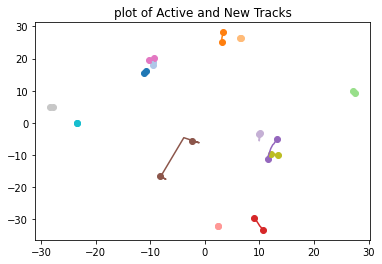

In [61]:
TrackTrack.iterate_for(10)

In [ ]:
cmap = plt.get_cmap('tab20')
num = len(cmap.colors)
colors = [cmap(i) for i in np.linspace(0,1,num)]
TrackTrack.print_tracks(colors,num)

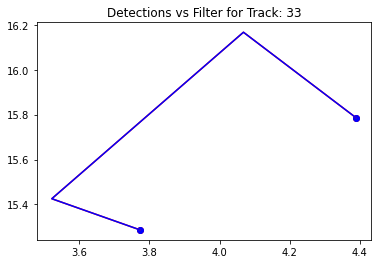

In [66]:
TrackTrack.tracks['Active'][10].detection_vs_filter()


-------------------------------- Iteration N°  1 --------------------------------
Active tracks:  8       New tracks:  9       Pending tracks:  0       Removed tracks:  10       Inactive tracks:  5


-------------------------------- Iteration N°  2 --------------------------------
Active tracks:  9       New tracks:  10       Pending tracks:  0       Removed tracks:  10       Inactive tracks:  5


-------------------------------- Iteration N°  3 --------------------------------
Active tracks:  9       New tracks:  10       Pending tracks:  0       Removed tracks:  11       Inactive tracks:  5


-------------------------------- Iteration N°  4 --------------------------------
Active tracks:  8       New tracks:  9       Pending tracks:  1       Removed tracks:  12       Inactive tracks:  5


-------------------------------- Iteration N°  5 --------------------------------
Active tracks:  9       New tracks:  12       Pending tracks:  1       Removed tracks:  12       Inactive tracks:  5

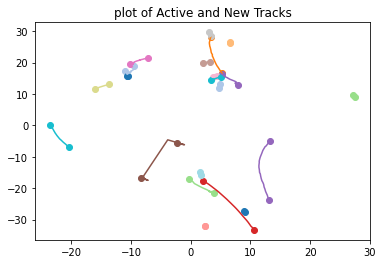

In [63]:
TrackTrack.iterate_for(10)